# Hybrid Filter for Image Enhancement

This Jupyter Notebook implements a hybrid filter for image enhancement, as described in the paper *A Hybrid Filter for Image Enhancement* by Shaomin Peng and Lori Lucke. The filter removes mixed Gaussian and impulsive noise from color images while preserving details.

## Filter Description
- **Step 1: Selective Peeling**: Removes impulsive noise (e.g., salt-and-pepper) by replacing pixels that deviate significantly from the median in a local window with the median value.
- **Step 2: Fuzzy Weighted Averaging**: Smooths Gaussian noise using a weighted average, with weights determined by a Gaussian-like fuzzy membership function based on pixel intensity differences.

## Usage
- **Prerequisites**:
  - Install Jupyter Notebook: `pip install jupyter`
  - Install dependencies: `pip install numpy matplotlib pillow ipywidgets`
  - Enable widgets: `jupyter nbextension enable --py widgetsnbextension`
  - For JupyterLab: `jupyter labextension install @jupyter-widgets/jupyterlab-manager`

- **Notes**:
  - If RGB histograms are identical (e.g., due to a grayscale image), Cell 8 will show high correlations (~1). Use Cell 5’s synthetic image or upload a colorful image.
  - The filter processes RGB channels separately to preserve color and does not use training data.
  - For best results, use images with mixed Gaussian and impulsive noise.

In [34]:
# Cell 2: Install Dependencies
# Purpose: Ensures required packages are installed (uncomment to run if needed).
# !pip install numpy matplotlib pillow ipywidgets

# Import Libraries
##### Purpose: Imports libraries for array operations, plotting, image handling, and interactive widgets.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
%matplotlib inline

# Define Hybrid Filter Function
##### Purpose: Implements the hybrid filter to remove mixed Gaussian and impulsive noise from color images.
- Step 1: Selective Peeling (removes impulsive noise using median replacement).
- Step 2: Fuzzy Weighted Averaging (smooths Gaussian noise with Gaussian-like weights).
- Processes RGB channels separately to preserve color.
- Optionally returns the peeled image for visualization.

In [36]:
def hybrid_filter(image, window_size=3, threshold=50, sigma=30, return_peeled=False):
    """
    Apply the hybrid filter to remove mixed Gaussian and impulsive noise.
    
    Parameters:
    - image: Input noisy image (H x W x 3 numpy array, RGB).
    - window_size: Size of the local neighborhood (3, 5, or 7).
    - threshold: Threshold for detecting impulsive noise.
    - sigma: Parameter for the Gaussian-like fuzzy weight function.
    - return_peeled: If True, return the peeled image (after Step 1).
    
    Returns:
    - filtered_image: Filtered image (H x W x 3 numpy array).
    - peeled_image: Peeled image (H x W x 3 numpy array, optional).
    """
    if window_size % 2 == 0:
        window_size += 1
    N = window_size // 2
    
    height, width, channels = image.shape
    peeled_image = np.copy(image).astype(np.float64)
    filtered_image = np.zeros_like(image, dtype=np.float64)
    
    # Step 1: Selective Peeling
    for channel in range(channels):
        for y in range(N, height - N):
            for x in range(N, width - N):
                window = image[y-N:y+N+1, x-N:x+N+1, channel]
                median_val = np.median(window)
                center_val = image[y, x, channel]
                if abs(center_val - median_val) > threshold:
                    peeled_image[y, x, channel] = median_val
    
    # Step 2: Fuzzy Weighted Averaging
    for channel in range(channels):
        for y in range(N, height - N):
            for x in range(N, width - N):
                window = peeled_image[y-N:y+N+1, x-N:x+N+1, channel]
                center_val = peeled_image[y, x, channel]
                weights = np.zeros((window_size, window_size))
                for j in range(window_size):
                    for i in range(window_size):
                        delta = abs(center_val - window[j, i])
                        weights[j, i] = np.exp(-delta**2 / (2 * sigma**2))
                weighted_sum = np.sum(weights * window)
                weight_total = np.sum(weights)
                filtered_image[y, x, channel] = weighted_sum / weight_total if weight_total > 0 else center_val
    
    # Handle borders
    filtered_image[:N, :, :] = peeled_image[:N, :, :]
    filtered_image[-N:, :, :] = peeled_image[-N:, :, :]
    filtered_image[:, :N, :] = peeled_image[:, :N, :]
    filtered_image[:, -N:, :] = peeled_image[:, -N:, :]
    
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)
    if return_peeled:
        peeled_image = np.clip(peeled_image, 0, 255).astype(np.uint8)
        return filtered_image, peeled_image
    return filtered_image

# Create Interactive Interface
##### Purpose: Sets up widgets for uploading an image and specifying filter parameters.
- Stores image and parameters in global variables.


In [ ]:
# Global variables
global_image = None  # Reset to allow synthetic image or upload
global_window_size = 3
global_threshold = 50
global_sigma = 30

def create_interactive_filter():
    upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Image')
    window_size = widgets.Dropdown(options=[3, 5, 7], value=3, description='Window Size:')
    threshold = widgets.IntSlider(min=10, max=100, value=50, description='Threshold:')
    sigma = widgets.IntSlider(min=10, max=100, value=30, description='Sigma:')
    apply_button = widgets.Button(description='Apply Filter', button_style='primary')
    output = widgets.Output()
    
    display(widgets.VBox([upload, window_size, threshold, sigma, apply_button, output]))
    
    def on_apply_button_clicked(b):
        with output:
            clear_output()
            if not upload.value:
                print('Please upload an image first!')
                return
            uploaded_file = upload.value[0]
            image = Image.open(io.BytesIO(uploaded_file['content']))
            image = np.array(image.convert('RGB'))
            global global_image, global_window_size, global_threshold, global_sigma
            global_image = image
            global_window_size = window_size.value
            global_threshold = threshold.value
            global_sigma = sigma.value
            print('Image uploaded. Run the next cells to apply the filter.')
    
    apply_button.on_click(on_apply_button_clicked)

create_interactive_filter()

# Cell 7: Apply Filter and Display Images
##### Purpose: Applies the hybrid filter using the uploaded or synthetic image and parameters.
- Displays original, peeled, and filtered images in a 1x3 subplot.

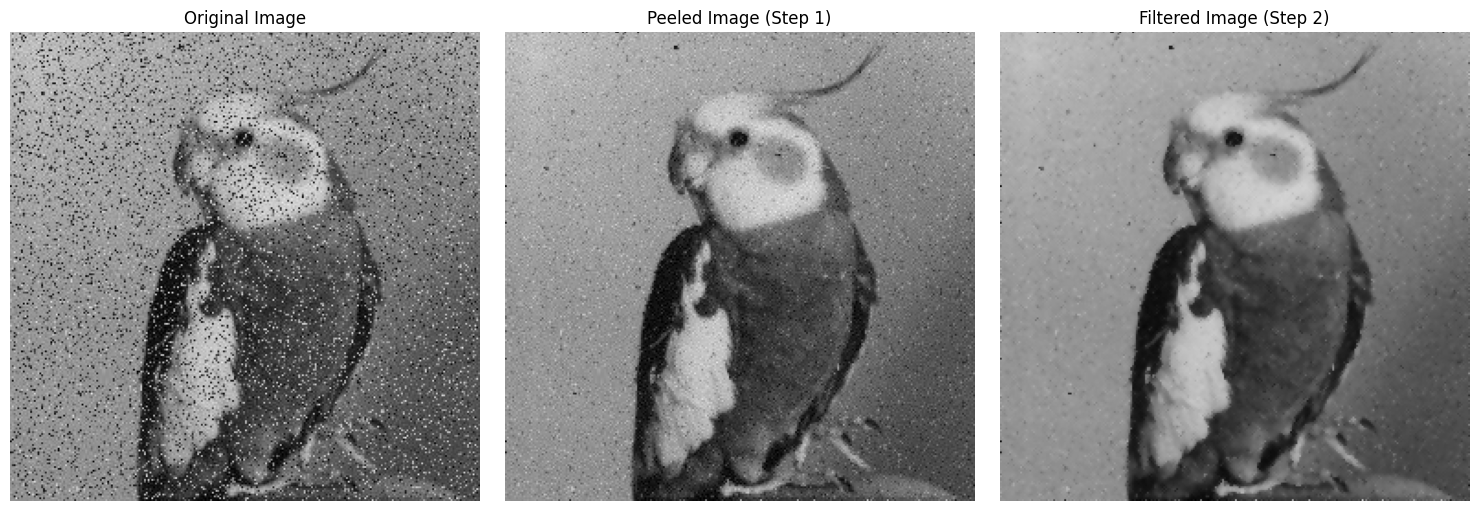

In [41]:
if global_image is None:
    print('Please run Cell 5 to generate a synthetic image or Cell 6 to upload an image first!')
else:
    filtered_image, peeled_image = hybrid_filter(
        global_image, global_window_size, global_threshold, global_sigma, return_peeled=True
    )
    
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(global_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(peeled_image)
    plt.title('Peeled Image (Step 1)')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(filtered_image)
    plt.title('Filtered Image (Step 2)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize Histograms and Difference Image
##### Purpose: Analyzes the filter's effect using histograms and a difference image.
- Histograms: Plots RGB channel intensities for original and filtered images.
- Difference Image: Shows |original - filtered| to highlight noise removal.


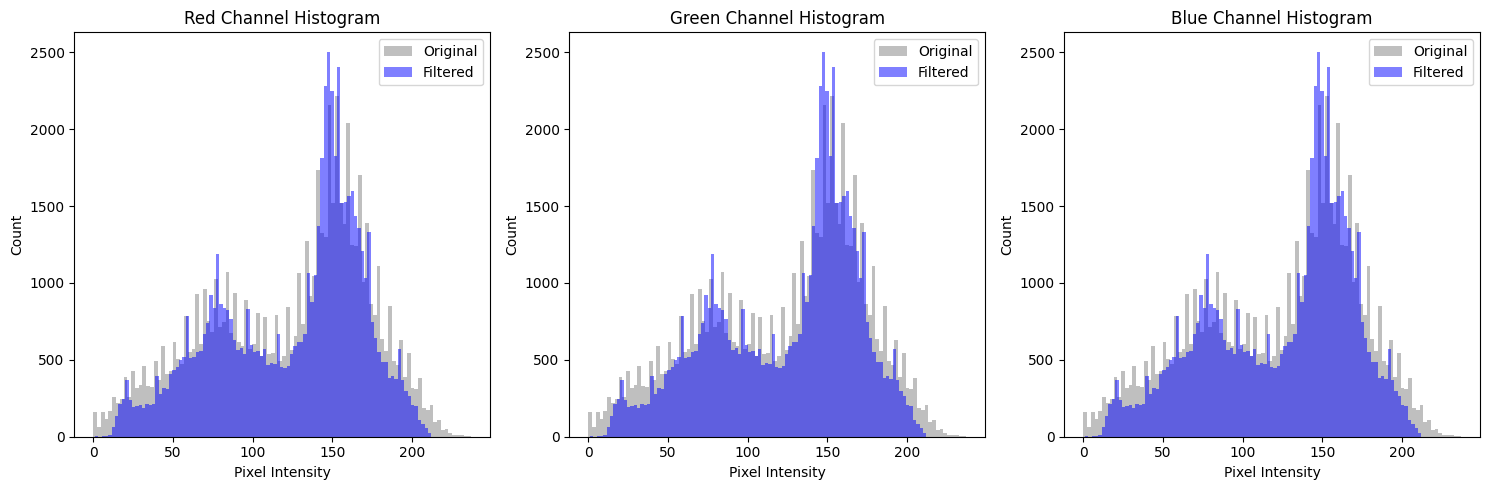

In [42]:

if global_image is None or 'filtered_image' not in locals():
    print('Please run the previous cells to generate or upload an image and apply the filter first!')
else:
    plt.figure(figsize=(15, 5))
    colors = ['Red', 'Green', 'Blue']
    for i, color in enumerate(colors):
        plt.subplot(1, 3, i+1)
        plt.hist(global_image[:, :, i].ravel(), bins=100, color='gray', alpha=0.5, label='Original', density=False)
        plt.hist(filtered_image[:, :, i].ravel(), bins=100, color='blue', alpha=0.5, label='Filtered', density=False)
        plt.title(f'{color} Channel Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')
        plt.legend()
    plt.tight_layout()
    plt.show()

<Figure size 1500x500 with 0 Axes>

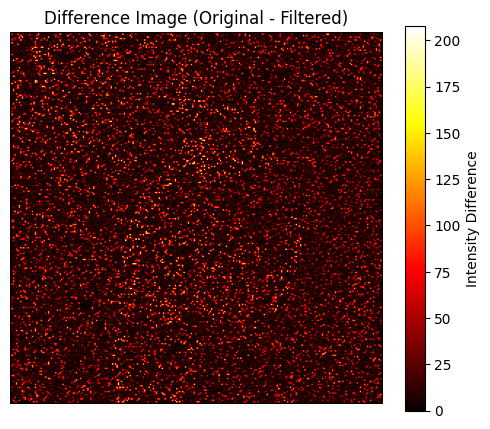

In [43]:
if global_image is None or 'filtered_image' not in locals():
    print('Please run the previous cells to generate or upload an image and apply the filter first!')
else:
    plt.figure(figsize=(15, 5))
    colors = ['Red', 'Green', 'Blue']
    diff_image = np.abs(global_image.astype(np.float64) - filtered_image.astype(np.float64))
    diff_image = np.mean(diff_image, axis=2)
    plt.figure(figsize=(6, 5))
    plt.imshow(diff_image, cmap='hot')
    plt.colorbar(label='Intensity Difference')
    plt.title('Difference Image (Original - Filtered)')
    plt.axis('off')
    plt.show()